In [1]:
"""
Author: Christian Bouwense

Program that gets the revision for a page by user for a certain time interval and measures burstiness.
"""

import time
import random
import datetime as dt
import mwapi
import operator
import numpy as np
import dateutil.parser as dup
from matplotlib import pyplot as plt

get_revisions() is a wrapper for the MWAPI get() call. We are always going to want to query, get revisions, and accept the maximum amount of revisions. However, you can also specify things like the revision properties you want, and the date range you wish to see (and if you don't really care, they have default values).

In [2]:
def get_revisions(title, rv_prop='timestamp|user', rv_start='today', rv_end='2000-01-01T00:00:00Z'):
    # Information specifying article and time interval to look at
    title = title
    
    # We're always going to want these parameters to be the same
    action = 'query'
    prop = 'revisions'
    rv_limit = 'max'
    
    today = dt.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%dT%H:%M:%SZ')
    # User can just give the string "today" instead of the timestamp
    if rv_start == "today":
        rv_start = today
    else:
        rv_start = start_date
    
    # Temporary dictionary holding amount of revisions for each user
    revisions_by_user = {}
    
    # Connect to Wikipedia
    session = mwapi.Session('https://en.wikipedia.org', user_agent='cbouwense')

    # Query Wikipedia for revisions on the supplied article
    # The result is stored into the dictionary "rev_dict"
    rev_dict = session.get(action=action,
                           prop=prop,
                           rvprop=rv_prop,
                           titles=title,
                           rvlimit=rv_limit,
                           rvstart=rv_start,
                           rvend=rv_end)
    
    # Find page_id for selected article
    for keys in rev_dict['query']['pages'].keys():
        page_id = keys
        
    # Go through the timestamps for each revision made.
    # If the timestamp is already a key in our dictionary, increment that key value by 1.
    # Else, create a new key for that year in our dictionary and set it to 1
    rev_timestamps = []
    for props in rev_dict['query']['pages'][str(page_id)]['revisions']:
        if 'user' in props:
            if (props['user'] not in revisions_by_user):
                revisions_by_user[props['user']] = 1
            else:
                revisions_by_user[props['user']] += 1

        timestamp = dup.parse(props['timestamp'])
        rev_timestamps.append(timestamp)
        
    # Check if there is a section named "continue".
    # If there is, that means the query did not get all the data
    # because of the per-user query limits.
    print ("Retrieving data on %s from Wikipedia..." % title)
    while 'continue' in rev_dict:
        continue_val = rev_dict['continue']['rvcontinue']
        rev_dict = session.get(action=action,
                               prop=prop,
                               rvprop=rv_prop,
                               titles=title,
                               rvlimit=rv_limit,
                               rvstart=today,
                               rvend=rv_end,
                               rvcontinue=continue_val)
        for props in rev_dict['query']['pages'][str(page_id)]['revisions']:
            if 'user' in props:
                if (props['user'] not in revisions_by_user):
                    revisions_by_user[props['user']] = 1
                else:
                    revisions_by_user[props['user']] += 1
            timestamp = dup.parse(props['timestamp'])
            rev_timestamps.append(timestamp)

    # List of tuples of revisions made by user for page
    sorted_user_revisions = sorted(revisions_by_user.items(), key=operator.itemgetter(1))[::-1]
    
    # Enumerate the times between events into a list
    interevent_times = []
    for i in range(0, len(rev_timestamps)-1):
        interevent_times.append((rev_timestamps[i] - rev_timestamps[i+1]).total_seconds())
    
    # Add data to global dictionaries
    article_data[title] = {}
    article_data[title]['user_revs'] = sorted_user_revisions
    article_data[title]['revision_times'] = rev_timestamps
    article_data[title]['interevent_times'] = interevent_times
    
    print ("Data received successfully!")

We will use a global dictionary to store the amount of revisions made by single users, and the interevent times for respective articles. They will be manipulated by get_revisions().

In [3]:
article_data = {}

get_revisions('Game of Thrones')

Retrieving data on Game of Thrones from Wikipedia.
This could take up to a few minutes depending on the article...
Data received successfully!


One of the ways of measuring burstiness is analyzing the distribution of the time between events in the system (interevent times). In order to do this, we need to find their mean and standard deviation. Luckily for us, the Python module Numpy has built-in functions for that.

The final step is to use the mean and standard deviation. The measure of burstiness by interevent times is defined as follows.
$$B \ \triangleq\ \frac{\sigma_{\tau}-m_{\tau}}{\sigma_{\tau}+m_{\tau}}$$

In [4]:
def get_B(title):
    # Calculate interevent time mean and standard deviation
    interevent_mean = (np.mean(article_data[title]['interevent_times']))
    interevent_std_dev = (np.std(article_data[title]['interevent_times']))
    B = ((interevent_std_dev - interevent_mean) / (interevent_std_dev + interevent_mean))
    article_data[title]['B'] = B

The value of B ranges from -1 to 1: the closer to -1 the more regular the events occur, closer to 0 means the closer they are to being completely random, and the closer to 1 the more bursty.

In [5]:
get_B('Game of Thrones')
print (article_data['Game of Thrones']['B'])

0.496478324097


There is a different angle that we can measure burstiness with: memory. At first it may sound the same but it is actually completely independent of interevent time distribution. Memory means that short interevent times are really likely to happen after short ones, and long ones occur after long ones.  

In order to measure this, we will need the mean and standard deviation of interevent times [1, n-1], and [2, n] (assuming a total of n interevent times).

The coefficient of burstiness due to memory is defined as

$$M \ \triangleq\ \frac{1}{n_{\tau} - 1}\sum_{i=1}^{n_{\tau}-1} \frac{(\tau_{i}-m_{1})(\tau_{i+1}-m_{2})}{\sigma_{1}\sigma_{2}}$$

In [6]:
def get_M(title):
    # Store times in this variable with a much shorter name
    times = article_data[title]['interevent_times']
    mean_1 = np.mean(times[0:len(times)-1])
    mean_2 = np.mean(times[1:len(times)])
    std_dev_1 = np.std(times[0:len(times)-1])
    std_dev_2 = np.std(times[1:len(times)])
    
    summation = 0
    for i in range(0, len(times)-1):
        tau_i = times[i]
        tau_i_plus_one = times[i+1]
        summation_term = (((tau_i - mean_1) * (tau_i_plus_one - mean_2)) / (std_dev_1 * std_dev_2)) 
        summation += summation_term

    M = (1 / (len(times) - 1)) * summation
    
    article_data[title]['M'] = M

In [7]:
article_data['Game of Thrones']['M'] = get_M('Game of Thrones')
print (article_data['Game of Thrones']['M'])

None


Now that we have easy ways to get revision data and statistics from articles, let's do it for a bunch of articles! I have chosen the top 15 articles with respect to number of edits, put them in a list, and get the data for each.

In [52]:
articles = [
'George W. Bush',
'List of WWE personnel',
'United States',
'Wikipedia',
'Michael Jackson',
'Jesus',
'Catholic Church',
'List of programs broadcast by ABS-CBN',
'Donald Trump',
'Barack Obama',
'Adolf Hitler',
'Britney Spears',
'World War II',
'The Beatles',
'India'
]

In [11]:
print ("Getting data for 15 articles.")
print ("This may take a while!")
for article in articles:
    get_revisions(article)

Getting data for 15 articles.
This may take a while!
Retrieving data on George W. Bush from Wikipedia.
This could take up to a few minutes depending on the article...
Data received successfully!
Retrieving data on List of WWE personnel from Wikipedia.
This could take up to a few minutes depending on the article...
Data received successfully!
Retrieving data on United States from Wikipedia.
This could take up to a few minutes depending on the article...
Data received successfully!
Retrieving data on Wikipedia from Wikipedia.
This could take up to a few minutes depending on the article...
Data received successfully!
Retrieving data on Michael Jackson from Wikipedia.
This could take up to a few minutes depending on the article...
Data received successfully!
Retrieving data on Jesus from Wikipedia.
This could take up to a few minutes depending on the article...
Data received successfully!
Retrieving data on Catholic Church from Wikipedia.
This could take up to a few minutes depending on th

Now let's visualize the data that we've collected! We're going to use a bar graph of the B and M values for each article we queried. Remember that B and M range from -1 to 1, and the closer to 1 they are the more they contributed to the data's burstiness.

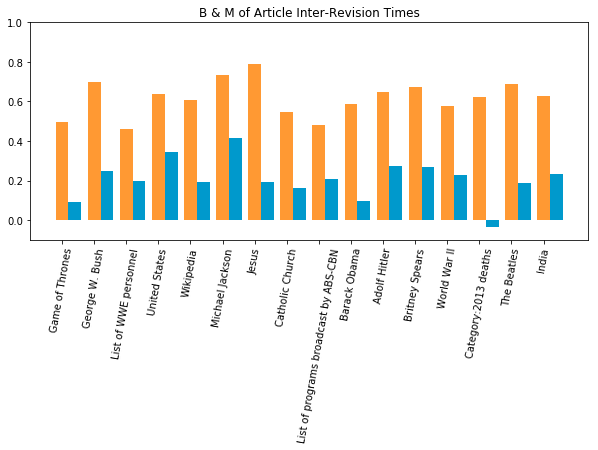

In [61]:
ind = np.arange(len(article_data.keys()))
B_vals = []
M_vals = []
for article in article_data.keys():
    B_vals.append(article_data[article]['B'])
    M_vals.append(article_data[article]['M'])
    
width = 0.4
fig, ax = plt.subplots()
#plt.figure(figsize=(20, 10))
plt.title('B & M of Article Inter-Revision Times')
plt.xticks(ind, article_data.keys(), rotation=80)
plt.ylim(-0.1, 1)

ax.bar(ind, B_vals, width, color='#FF9933', label='N')
ax.bar(ind + width, M_vals, width, color='#0099CC', label='M')

fig.set_size_inches(10, 4)

plt.show()